# Naïve Bayes Modeling

## Predicting the Character

In [60]:
#Importing necessary Libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

#Import Naive Bayes 
from sklearn.naive_bayes import MultinomialNB

#Other libraries needed 
from sklearn.metrics import (plot_confusion_matrix, accuracy_score, 
                             f1_score, classification_report)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

#For streamlit app
import pickle

In [2]:
#import the dataset
friends = pd.read_csv('../../Datasets/friends-modeling.csv')
friends.head()

,season,episode,character,dialogue
0,s01,e01,Monica Geller,There's nothing to tell! He's just some guy I ...
1,s01,e01,Joey Tribbiani,"C'mon, you're going out with the guy! There's ..."
2,s01,e01,Chandler Bing,"All right Joey, be nice. So does he have a hum..."
3,s01,e01,Phoebe Buffay,"Wait, does he eat chalk?"
4,s01,e01,Phoebe Buffay,"Just, 'cause, I don't want her to go through w..."


In [3]:
#Make sure no nulls
friends.isnull().sum()

season       0
episode      0
character    0
dialogue     0
dtype: int64

### Make X and y values 

In [4]:
X = friends['dialogue']
y = friends['character']

### Split into Train and Test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Baseline Accuracy 

In [6]:
#To compare the models to, this is the scores to beat.
y_train.value_counts(normalize=True)

Rachel Green      0.177657
Ross Geller       0.177152
Chandler Bing     0.169355
Monica Geller     0.167242
Joey Tribbiani    0.160725
Phoebe Buffay     0.147869
Name: character, dtype: float64

### Setting up a Pipe for all Naïve Bayes Modeling

In [7]:
# Get the same accuracy and scores 
np.random.seed(42)

In [8]:
pipe = Pipeline(steps=[('cv', CountVectorizer()),
                       ('mnb', MultinomialNB())
                      ])

### Modeling: Basic Model with Default Parameters and using CountVectorizer

In [9]:
grid_d = {'cv__stop_words':[None, 'english'],
               'cv__min_df': [0, 1, 2]}

In [10]:
# Instaniate a gridSearch object 
gs_d = GridSearchCV(estimator=pipe, param_grid=grid_d)
gs_d.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cv__min_df': [0, 1, 2],
                         'cv__stop_words': [None, 'english']})

In [11]:
#What are the best parameters?
gs_d.best_params_

{'cv__min_df': 0, 'cv__stop_words': None}

In [12]:
print(f'Train score: {gs_d.score(X_train, y_train)}\nTest score: {gs_d.score(X_test, y_test)}')

Train score: 0.479169146530175
Test score: 0.3076236386359579


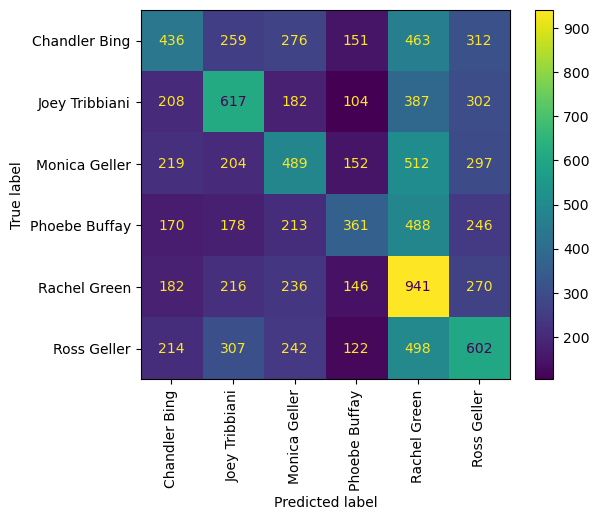

In [13]:
#Plotting a Confusion Matrix to show a comparison between actual and predicted values.
plot_confusion_matrix(estimator=gs_d, X = X_test, y_true=y_test)
plt.xticks(rotation = 90)
plt.show()

---
**Making Predictions**

In [14]:
preds_d = gs_d.predict(X_test)

In [15]:
#Checking the precision, recall, f1-score scores
print(classification_report(y_true=y_test, y_pred=preds_d))

                precision    recall  f1-score   support

 Chandler Bing       0.31      0.23      0.26      1897
Joey Tribbiani       0.35      0.34      0.34      1800
 Monica Geller       0.30      0.26      0.28      1873
 Phoebe Buffay       0.35      0.22      0.27      1656
  Rachel Green       0.29      0.47      0.36      1991
   Ross Geller       0.30      0.30      0.30      1985

      accuracy                           0.31     11202
     macro avg       0.31      0.30      0.30     11202
  weighted avg       0.31      0.31      0.30     11202



In [16]:
#Checking the accuracy score for this model 
accuracy_score(y_true=y_test, y_pred=preds_d)

0.3076236386359579

---
**Making a dataframe with actual, predictions, and dialogue**

In [17]:
nb_d = pd.DataFrame(y_test)

nb_d['predictions'] = preds_d

nb_d['dialogue'] = X_test

nb_d.rename(columns={'character': 'actual'}, inplace=True)
nb_d.head(10)

,actual,predictions,dialogue
8260,Monica Geller,Ross Geller,Then what's the problem?
12970,Phoebe Buffay,Rachel Green,"Yeah, well, everybody does! I'm a really cool ..."
9682,Rachel Green,Rachel Green,What? What? He's interested in you. He-he like...
22017,Monica Geller,Rachel Green,I've never loved anybody as much as I love you.
5611,Rachel Green,Rachel Green,And I'm in it? Then let me read it.
22331,Joey Tribbiani,Joey Tribbiani,"Yeah, I gotta go! I got an acting job. Like yo..."
18609,Monica Geller,Phoebe Buffay,Great. So the ball is in his court?
23737,Monica Geller,Monica Geller,"Dad, please don't pick your teeth out here! Al..."
35446,Ross Geller,Joey Tribbiani,"Excellent! Excellent, now-now do you want anot..."
3756,Monica Geller,Monica Geller,How are you?


In [18]:
#Checking which character was predicted the most by this model 
nb_d['predictions'].value_counts()

Rachel Green      3289
Ross Geller       2029
Joey Tribbiani    1781
Monica Geller     1638
Chandler Bing     1429
Phoebe Buffay     1036
Name: predictions, dtype: int64

In [19]:
#How many times the character actually appears 
nb_d['actual'].value_counts()

Rachel Green      1991
Ross Geller       1985
Chandler Bing     1897
Monica Geller     1873
Joey Tribbiani    1800
Phoebe Buffay     1656
Name: actual, dtype: int64

In [20]:
#How many predictions were wrong?
nb_d.loc[nb_d['actual']!= nb_d['predictions']].count()

actual         7756
predictions    7756
dialogue       7756
dtype: int64

In [21]:
#How many were right?
nb_d.loc[nb_d['actual']== nb_d['predictions']].count()

actual         3446
predictions    3446
dialogue       3446
dtype: int64

---
**Predicting Some Phrases**

In [54]:
gs_d.predict(["How you doin'?"])[0]

'Joey Tribbiani'

In [55]:
gs_d.predict(['Smelly cat, smelly cat, what are they feeding you'])[0]

'Phoebe Buffay'

In [56]:
gs_d.predict(['We were on a break!'])[0]

'Ross Geller'

----
### Trying with Parameters!

In [22]:
grid_1 = {'cv__stop_words':[None, 'english'],
          'mnb__alpha': np.linspace(0.5, 0.9, 3),
          'mnb__fit_prior': [True, False]
         }

In [23]:
gs_1 = GridSearchCV(estimator=pipe, param_grid=grid_1)
gs_1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cv__stop_words': [None, 'english'],
                         'mnb__alpha': array([0.5, 0.7, 0.9]),
                         'mnb__fit_prior': [True, False]})

In [24]:
gs_1.best_params_

{'cv__stop_words': None, 'mnb__alpha': 0.7, 'mnb__fit_prior': False}

In [25]:
print(f'Train score: {gs_1.score(X_train, y_train)}\nTest score: {gs_1.score(X_test, y_test)}')

Train score: 0.49211403404356624
Test score: 0.31012319228709156


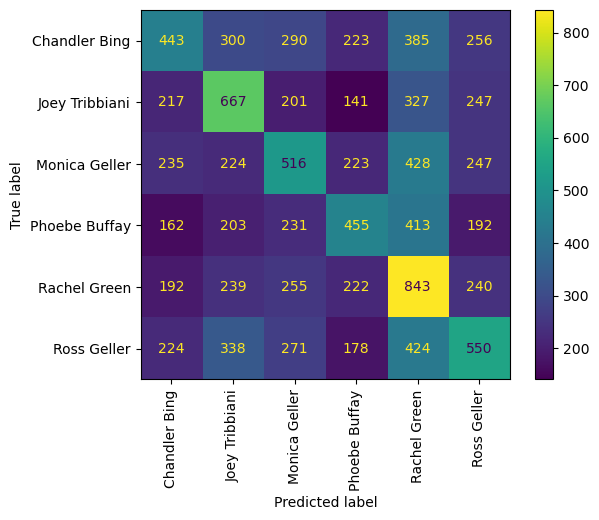

In [26]:
#Plotting a Confusion Matrix to show a comparison between actual and predicted values.
plot_confusion_matrix(estimator=gs_1, X = X_test, y_true=y_test)
plt.xticks(rotation = 90)
plt.show()

---
**Making Predictions**

In [27]:
preds_1 = gs_1.predict(X_test)

In [28]:
#Checking the precision, recall, f1-score scores
print(classification_report(y_true=y_test, y_pred=preds_1))

                precision    recall  f1-score   support

 Chandler Bing       0.30      0.23      0.26      1897
Joey Tribbiani       0.34      0.37      0.35      1800
 Monica Geller       0.29      0.28      0.28      1873
 Phoebe Buffay       0.32      0.27      0.29      1656
  Rachel Green       0.30      0.42      0.35      1991
   Ross Geller       0.32      0.28      0.30      1985

      accuracy                           0.31     11202
     macro avg       0.31      0.31      0.31     11202
  weighted avg       0.31      0.31      0.31     11202



In [29]:
#Checking the accuracy score for this model 
accuracy_score(y_true=y_test, y_pred=preds_1)

0.31012319228709156

---
**Making a dataframe with actual, predictions, and dialogue**

In [30]:
nb_df_1 = pd.DataFrame(y_test)

nb_df_1['predictions'] = preds_1

nb_df_1['dialogue'] = X_test

nb_df_1.rename(columns={'character': 'actual'}, inplace=True)
nb_df_1.head(10)

,actual,predictions,dialogue
8260,Monica Geller,Joey Tribbiani,Then what's the problem?
12970,Phoebe Buffay,Rachel Green,"Yeah, well, everybody does! I'm a really cool ..."
9682,Rachel Green,Rachel Green,What? What? He's interested in you. He-he like...
22017,Monica Geller,Monica Geller,I've never loved anybody as much as I love you.
5611,Rachel Green,Rachel Green,And I'm in it? Then let me read it.
22331,Joey Tribbiani,Joey Tribbiani,"Yeah, I gotta go! I got an acting job. Like yo..."
18609,Monica Geller,Phoebe Buffay,Great. So the ball is in his court?
23737,Monica Geller,Monica Geller,"Dad, please don't pick your teeth out here! Al..."
35446,Ross Geller,Joey Tribbiani,"Excellent! Excellent, now-now do you want anot..."
3756,Monica Geller,Monica Geller,How are you?


In [31]:
#Checking which character was predicted the most by this model 
nb_df_1['predictions'].value_counts()

Rachel Green      2820
Joey Tribbiani    1971
Monica Geller     1764
Ross Geller       1732
Chandler Bing     1473
Phoebe Buffay     1442
Name: predictions, dtype: int64

In [32]:
#How many times the character actually appears 
nb_df_1['actual'].value_counts()

Rachel Green      1991
Ross Geller       1985
Chandler Bing     1897
Monica Geller     1873
Joey Tribbiani    1800
Phoebe Buffay     1656
Name: actual, dtype: int64

In [33]:
#How many predictions were wrong?
nb_df_1.loc[nb_d['actual']!= nb_df_1['predictions']].count()

actual         7728
predictions    7728
dialogue       7728
dtype: int64

In [34]:
#How many were right?
nb_df_1.loc[nb_d['actual']== nb_df_1['predictions']].count()

actual         3474
predictions    3474
dialogue       3474
dtype: int64

---
**Predicting Some Phrases**

In [35]:
gs_1.predict(["How you doin'?"])[0]

'Joey Tribbiani'

In [36]:
gs_1.predict(['Smelly cat, smelly cat, what are they feeding you'])[0]

'Phoebe Buffay'

In [37]:
gs_1.predict(['We were on a break!'])[0]

'Ross Geller'

----
#### More hyperparameter tuning!

In [38]:
grid_2 = {'cv__stop_words':[None, 'english'],
          'mnb__alpha': np.linspace(0.5, 1.5, 6),
          'mnb__fit_prior': [True, False]
         }

In [39]:
gs_2 = GridSearchCV(estimator=pipe, param_grid=grid_2)
gs_2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cv__stop_words': [None, 'english'],
                         'mnb__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'mnb__fit_prior': [True, False]})

In [40]:
gs_2.best_params_

{'cv__stop_words': None, 'mnb__alpha': 0.7, 'mnb__fit_prior': False}

In [41]:
print(f'Train score: {gs_2.score(X_train, y_train)}\nTest score: {gs_2.score(X_test, y_test)}')

Train score: 0.49211403404356624
Test score: 0.31012319228709156


***Same best parameters as before, so no need to go further with this one.***
